In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, models, transforms
from numpy import linalg as LA
sys.path.append('../environments/')
from sepsis_env import SepsisEnv

In [2]:
env = SepsisEnv()
fg_tuples = env.generate_tuples(group="foreground", n_trajectories=10)
bg_tuples = env.generate_tuples(group="background", n_trajectories=10)
all_tuples = bg_tuples + fg_tuples
random.shuffle(all_tuples)
split = 0.8
train_tuples = all_tuples[:int(split*len(all_tuples))]
test_tuples = all_tuples[int(split*len(all_tuples)):]

In [3]:
class ContrastiveDataset(Dataset):
    def __init__(self, tuples):
        self.tuples = tuples
            
        def construct_pairs(tuples):
            X = []
            y = []
            for t in self.tuples:
                if t[4] == 'background':
                    one_hot_a = [0]*25
                    s = t[0]
                    a = t[1]
                    one_hot_a[a] = 1
                    r = t[3][0]
                    if r == 0:
                        r = 0.00000001
                    
                    blank_s = [0]*46
                    blank_a = [0]
                    s_a = np.hstack((s, a, blank_s, blank_a))
                    X.append(s_a)
                    y.append(r)
                else:
                    one_hot_a = [0]*25
                    s = t[0]
                    a = t[1]
                    one_hot_a[a] = 1
                    r = t[3][0]
                    if r == 0:
                        r = 0.00000001
                    
                    s_a = np.hstack((s, a, s, a))
                    X.append(s_a)
                    y.append(r)
            return X, y
    
        self.X, self.y = construct_pairs(self.tuples)

    def __len__(self):
        return len(self.tuples)

    def __getitem__(self,idx):
        return (self.X[idx], self.y[idx])

In [4]:
class LinearContrastiveNet(nn.Module):
    def __init__(self):
        super(LinearContrastiveNet, self).__init__()
        
        self.fc1 = nn.Linear(94, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

100%|██████████| 131/131 [00:00<00:00, 7979.64it/s]
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

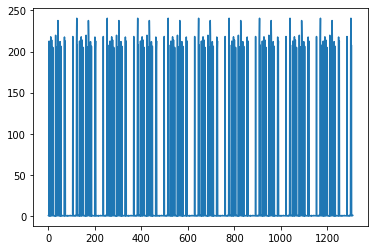

In [6]:
model = LinearContrastiveNet()
train_ds=ContrastiveDataset(train_tuples)
test_ds=ContrastiveDataset(test_tuples)
model.apply(weights_init)
optimizer = SGD(model.parameters(), lr=0.001)
num_epochs = 10
criterion = nn.MSELoss()    
losses = []
for epoch in range(num_epochs):
    for i, (s_a, r) in enumerate(tqdm.tqdm(train_ds)):
        s_a = torch.Tensor(s_a)
        r = torch.Tensor([r])
        model.train()
        pred_r = model(s_a)
        train_loss = criterion(pred_r, r)
        losses.append(train_loss.detach().cpu().numpy().item())
iterations = [i for i in range(len(losses))]
sns.lineplot(iterations, losses)

# Interpretability

In [11]:
# First 47 elements are shared, second 47 are fg specific
model.fc1.weight

Parameter containing:
tensor([[-0.0742, -0.1075,  0.1810,  0.0949, -0.1885, -0.0388, -0.0105,  0.0248,
          0.0426,  0.0417, -0.1410, -0.1298,  0.1532,  0.0274, -0.0362, -0.0724,
         -0.2058,  0.1815,  0.0703, -0.0940, -0.1629,  0.0064,  0.0671, -0.0068,
         -0.1578, -0.0014, -0.2202, -0.0579, -0.0713,  0.0034, -0.1557,  0.0669,
         -0.0677,  0.1935, -0.0045,  0.0444,  0.0388,  0.0452,  0.0282,  0.0633,
         -0.0341, -0.1366,  0.0414, -0.0371, -0.0145,  0.1329, -0.0216,  0.1659,
          0.0327,  0.1750,  0.0594,  0.0489, -0.0185,  0.1622, -0.2351, -0.1601,
          0.1462,  0.1666, -0.0491,  0.0261,  0.0728, -0.0590, -0.0842, -0.0262,
         -0.0460, -0.1130,  0.0567, -0.1078,  0.0462, -0.3140, -0.2036,  0.1549,
          0.0439,  0.0467, -0.1050,  0.1145,  0.2037,  0.1235, -0.1622, -0.0188,
         -0.1390, -0.1475,  0.0720,  0.0304, -0.0510, -0.0818,  0.1081, -0.0115,
         -0.0446, -0.1275, -0.0772,  0.1093, -0.0752,  0.0823]],
       requires_grad=T

In [12]:
bg_weights = model.fc1.weight[0][:47]
fg_weights = model.fc1.weight[0][47:]

<AxesSubplot:>

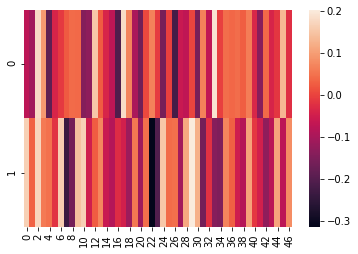

In [23]:
# 1 is fg, 0 is bg. This is the contrastive representation. 
sns.heatmap([bg_weights.detach().cpu().numpy(), fg_weights.detach().cpu().numpy()])